<a href="https://colab.research.google.com/github/k-vinamr/rera_construction_pred/blob/main/25_oct_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
# Load your dataset
data = pd.read_csv('new_6_floor.csv')  # Replace with your actual data file

In [2]:
data['total_built_up_area_saleable_area'].describe()

count     1372.000000
mean      1806.428302
std       1705.358423
min        141.600000
25%        787.185000
50%       1207.665000
75%       2088.717500
max      15581.990000
Name: total_built_up_area_saleable_area, dtype: float64

In [3]:
# Converting date columns to datetime objects
data['actual_commencement_date'] = pd.to_datetime(data['actual_commencement_date'], format='%d-%m-%Y', errors='coerce')
data['estimated_finish_date'] = pd.to_datetime(data['estimated_finish_date'], format='%d-%m-%Y', errors='coerce')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 40 columns):
 #   Column                                                                     Non-Null Count  Dtype         
---  ------                                                                     --------------  -----         
 0   organisation_name                                                          1372 non-null   object        
 1   project_category                                                           1372 non-null   object        
 2   actual_commencement_date                                                   1372 non-null   datetime64[ns]
 3   estimated_finish_date                                                      1372 non-null   datetime64[ns]
 4   total_built_up_area_saleable_area                                          1372 non-null   float64       
 5   total_area_of_project                                                      1372 non-null   float64       
 6   

In [5]:
current_date = datetime.now()

In [6]:
data['duration_since_commencement'] = (current_date - data['actual_commencement_date']).dt.days
data['remaining_duration'] = (data['estimated_finish_date'] - current_date).dt.days
data['progress_ratio'] = data['duration_since_commencement'] / data['total_days']

In [7]:
# Define a function to determine the project status
def determine_status(row):
    if current_date > row['estimated_finish_date']:
        return 'completed'
    elif current_date >= row['actual_commencement_date']:
        return 'running'
    else:
        return 'upcoming'

# Apply the function to create the 'Status' column
data['current_stage'] = data.apply(determine_status, axis=1)

# Print the DataFrame with the 'Status' column
data

,organisation_name,project_category,actual_commencement_date,estimated_finish_date,total_built_up_area_saleable_area,total_area_of_project,floor,project_state,total_days,Cleaning & survey,...,"Electrical concealed, PVC Fitting, plastering at 3rd-6th floor",Plastering on outer sides,Tiles work,Painting and Finishing,"Plumbing & Sanitary,Electrification Works",Doors & Windows Fixing Furniture work,duration_since_commencement,remaining_duration,progress_ratio,current_stage
0,NITIN Last Name DOLKE,Residential/Group Housing,2022-02-16,2022-06-02,1251.72,480.0,6,MAHARASHTRA,106,0.633214,...,8.864994,9.498208,7.598566,10.131422,5.698925,8.864994,616,-511,5.811321,completed
1,SARYASH CONSTRUCTIONS,Residential/Group Housing,2018-04-13,2018-07-31,464.66,279.0,6,MAHARASHTRA,109,0.651135,...,9.115890,9.767025,7.813620,10.418160,5.860215,9.115890,2021,-1913,18.541284,completed
2,Murtuz Abdul Razzaque Kotkunde,Residential/Group Housing,2021-09-13,2021-12-31,417.71,226.6,6,MAHARASHTRA,109,0.651135,...,9.115890,9.767025,7.813620,10.418160,5.860215,9.115890,772,-664,7.082569,completed
3,PATIL AND MANURE ASSOCIATES,Residential/Group Housing,2021-09-09,2021-12-30,690.65,511.5,6,MAHARASHTRA,112,0.669056,...,9.366786,10.035842,8.028674,10.704898,6.021505,9.366786,776,-665,6.928571,completed
4,GANGA BUILDERS AND DEVELOPERS,Residential/Group Housing,2021-09-09,2021-12-30,965.40,471.0,6,MAHARASHTRA,112,0.669056,...,9.366786,10.035842,8.028674,10.704898,6.021505,9.366786,776,-665,6.928571,completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,SARWDNYA BUILDCON,Residential/Group Housing,2022-04-01,2029-12-31,2351.60,837.0,6,MAHARASHTRA,2831,16.911589,...,236.762246,253.673835,202.939068,270.585424,152.204301,236.762246,572,2258,0.202049,running
1368,ABHISHEK SUBHASH NIKAM,Residential/Group Housing,2022-10-27,2030-12-31,9163.48,3557.3,6,MAHARASHTRA,2987,17.843489,...,249.808841,267.652330,214.121864,285.495818,160.591398,249.808841,363,2623,0.121527,running
1369,MANSI BUILDERS AND DEVELOPERS,Residential/Group Housing,2021-09-09,2030-03-31,9597.12,9100.0,6,MAHARASHTRA,3125,18.667861,...,261.350060,280.017921,224.014337,298.685783,168.010753,261.350060,776,2348,0.248320,running
1370,DATTATRAY DINKAR CHAVAN,Residential/Group Housing,2022-12-12,2032-12-31,2398.58,1700.5,6,MAHARASHTRA,3672,21.935484,...,307.096774,329.032258,263.225806,350.967742,197.419355,307.096774,317,3354,0.086329,running


In [8]:
# Assuming you have your data in a DataFrame named df
# If it's not, you can read your data from a CSV or any other source

# Define the bin edges
bin_width = 500
max_value = int(data['total_built_up_area_saleable_area'].max())
bin_edges = list(range(0, max_value + bin_width, bin_width))  # Creates bins of size 500

# Create a new column to store the bin labels
data['area_bin'] = pd.cut(data['total_built_up_area_saleable_area'], bin_edges)

# Group the data by the 'area_bin' column
grouped = data.groupby('area_bin')

# Define the features you want to analyze
features = ['total_days']  # Add more features as needed

# Iterate over the groups and calculate min and max for each feature
for feature in features:
    data_min = grouped[feature].min()
    data_max = grouped[feature].max()
    data_mean = grouped[feature].mean()
    data_count = grouped[feature].count()
    result = pd.concat([data_min, data_max, data_mean, data_count], axis=1)
    result.columns = ['Min', 'Max', 'Mean', 'Count']
    print(f"Statistics for '{feature}':")
    print(result)
    print("\n")

Statistics for 'total_days':
                   Min     Max         Mean  Count
area_bin                                          
(0, 500]         109.0  1778.0   708.051546     97
(500, 1000]      112.0  3764.0   809.482143    448
(1000, 1500]     106.0  2147.0   897.385382    301
(1500, 2000]     114.0  2383.0   991.025641    156
(2000, 2500]     288.0  3672.0  1106.887640     89
(2500, 3000]     113.0  1950.0  1032.527273     55
(3000, 3500]     143.0  2334.0  1132.113208     53
(3500, 4000]     421.0  2302.0  1147.459459     37
(4000, 4500]     462.0  1887.0  1161.470588     34
(4500, 5000]     469.0  1836.0  1043.458333     24
(5000, 5500]     761.0  1795.0  1145.214286     14
(5500, 6000]     122.0  1822.0  1098.782609     23
(6000, 6500]     418.0  1604.0  1081.363636     11
(6500, 7000]     612.0  1895.0  1163.600000      5
(7000, 7500]     454.0   964.0   786.600000      5
(7500, 8000]     112.0  1811.0   652.625000      8
(8000, 8500]       NaN     NaN          NaN      0
(8

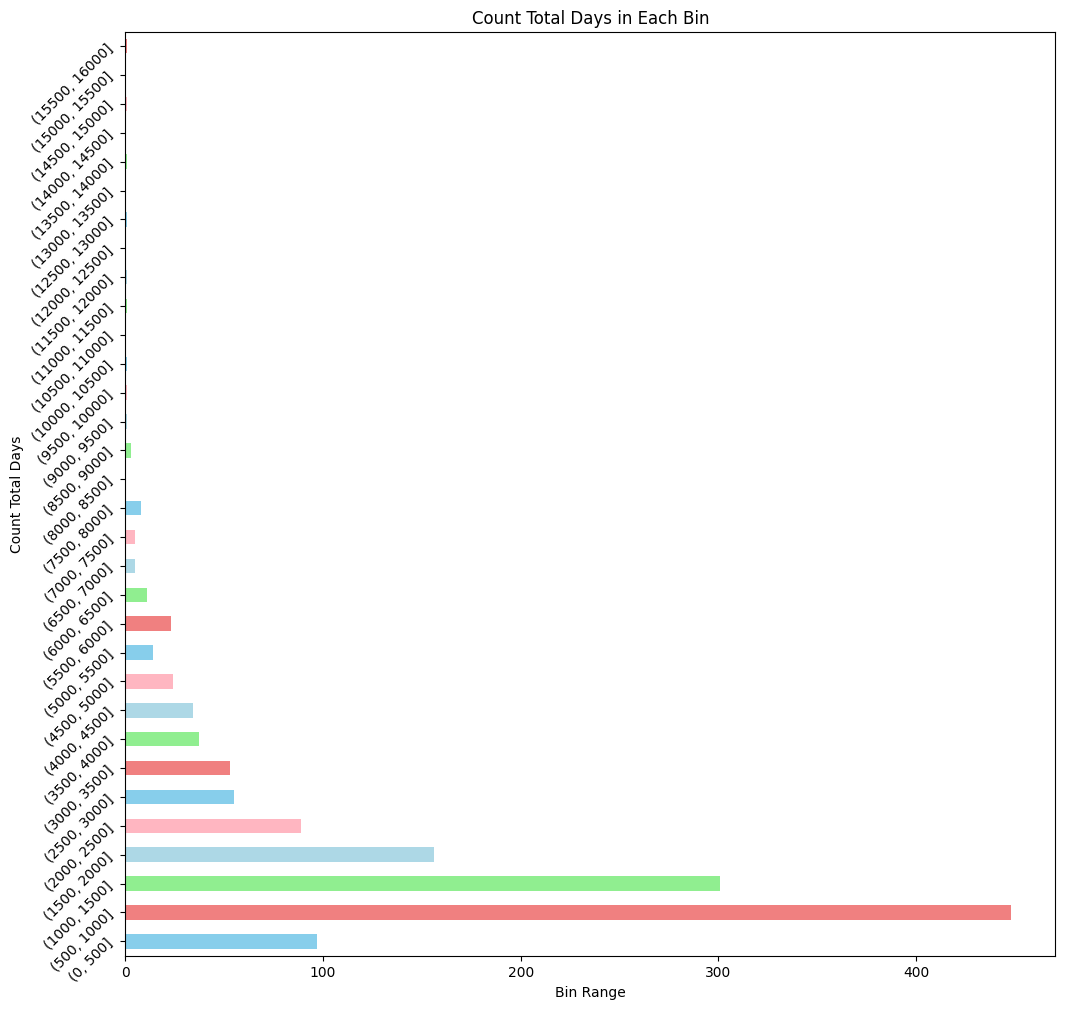

In [9]:
# Create a bar chart for the mean values
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightpink']
plt.figure(figsize=(12, 12))
data_count.plot(kind='barh', color=colors)
plt.xlabel('Bin Range')
plt.ylabel('Count Total Days')
plt.title('Count Total Days in Each Bin')
plt.yticks(range(len(data_count)), data_count.index, rotation=45)
plt.show()

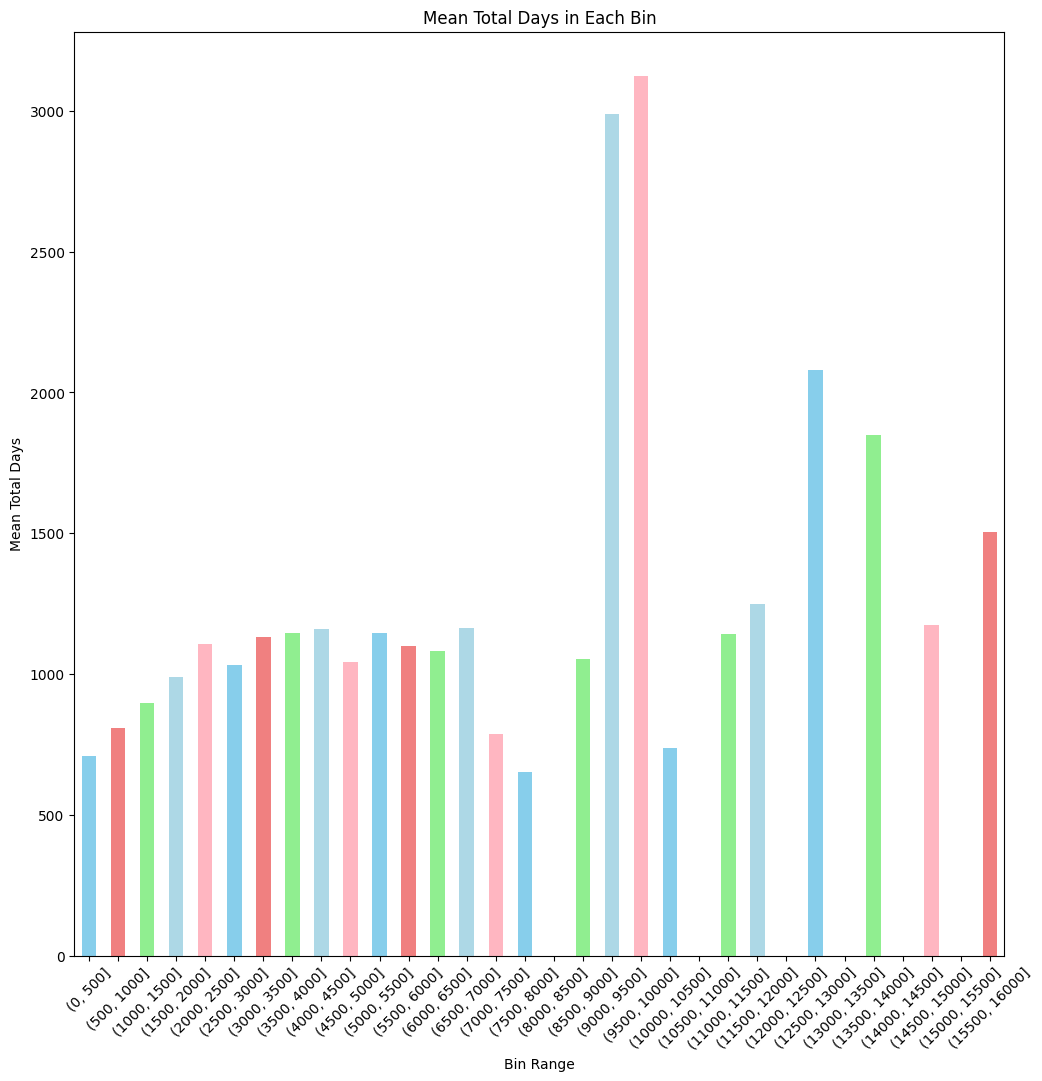

In [10]:
# Create a bar chart for the mean values
plt.figure(figsize=(12, 12))
data_mean.plot(kind='bar', color=colors)
plt.xlabel('Bin Range')
plt.ylabel('Mean Total Days')
plt.title('Mean Total Days in Each Bin')
plt.xticks(range(len(data_mean)), data_mean.index, rotation=45)
plt.show()

In [11]:
# Filter the DataFrame based on the condition
filtered_data = data[data['total_built_up_area_saleable_area'] < 8000]

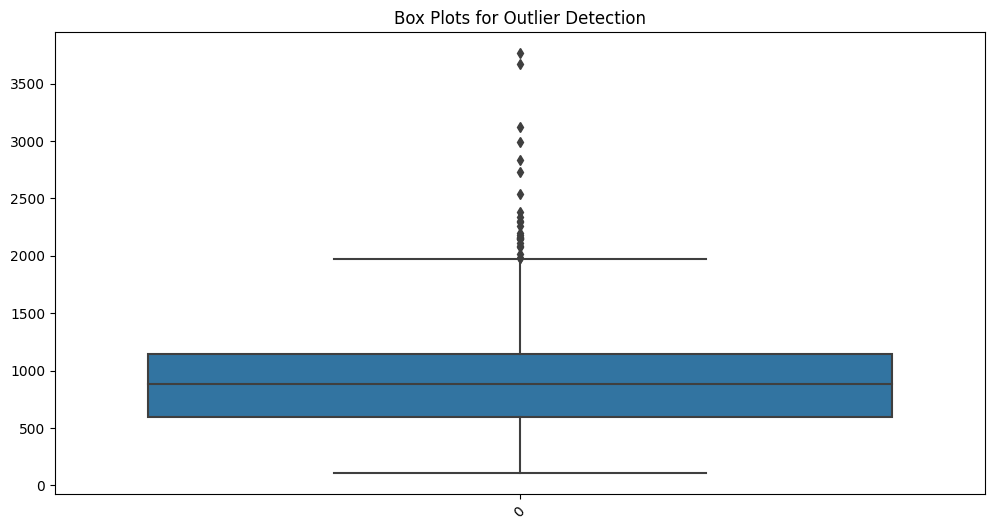

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data['total_days'])
plt.title('Box Plots for Outlier Detection')
plt.xticks(rotation=45)
plt.show()

In [13]:
# Get numerical and categorical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Example: Remove outliers based on IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_filtered = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data_filtered

for column in data[numerical_columns]:
    data = remove_outliers_iqr(data, column)

In [14]:
data['total_days'].count()

860

In [15]:
# Assuming you have your data in a DataFrame named df
# If it's not, you can read your data from a CSV or any other source

# Define the bin edges
bin_width = 500
max_value = int(data['total_built_up_area_saleable_area'].max())
bin_edges = list(range(0, max_value + bin_width, bin_width))  # Creates bins of size 500

# Create a new column to store the bin labels
data['area_bin'] = pd.cut(data['total_built_up_area_saleable_area'], bin_edges)

# Group the data by the 'area_bin' column
grouped = data.groupby('area_bin')

# Define the features you want to analyze
features = ['total_days']  # Add more features as needed

# Iterate over the groups and calculate min and max for each feature
for feature in features:
    data_min = grouped[feature].min()
    data_max = grouped[feature].max()
    data_mean = grouped[feature].mean()
    data_count = grouped[feature].count()
    result = pd.concat([data_min, data_max, data_mean, data_count], axis=1)
    result.columns = ['Min', 'Max', 'Mean', 'Count']
    print(f"Statistics for '{feature}':")
    print(result)
    print("\n")


Statistics for 'total_days':
               Min   Max         Mean  Count
area_bin                                    
(0, 500]       341  1778   874.112903     62
(500, 1000]    182  1828   913.463190    326
(1000, 1500]   335  1791   993.936652    221
(1500, 2000]   247  1874  1033.097087    103
(2000, 2500]   463  1800  1106.420000     50
(2500, 3000]   610  1825  1117.555556     36
(3000, 3500]   546  1826  1118.970588     34
(3500, 4000]   421  1833  1059.888889     27
(4000, 4500]  1117  1117  1117.000000      1




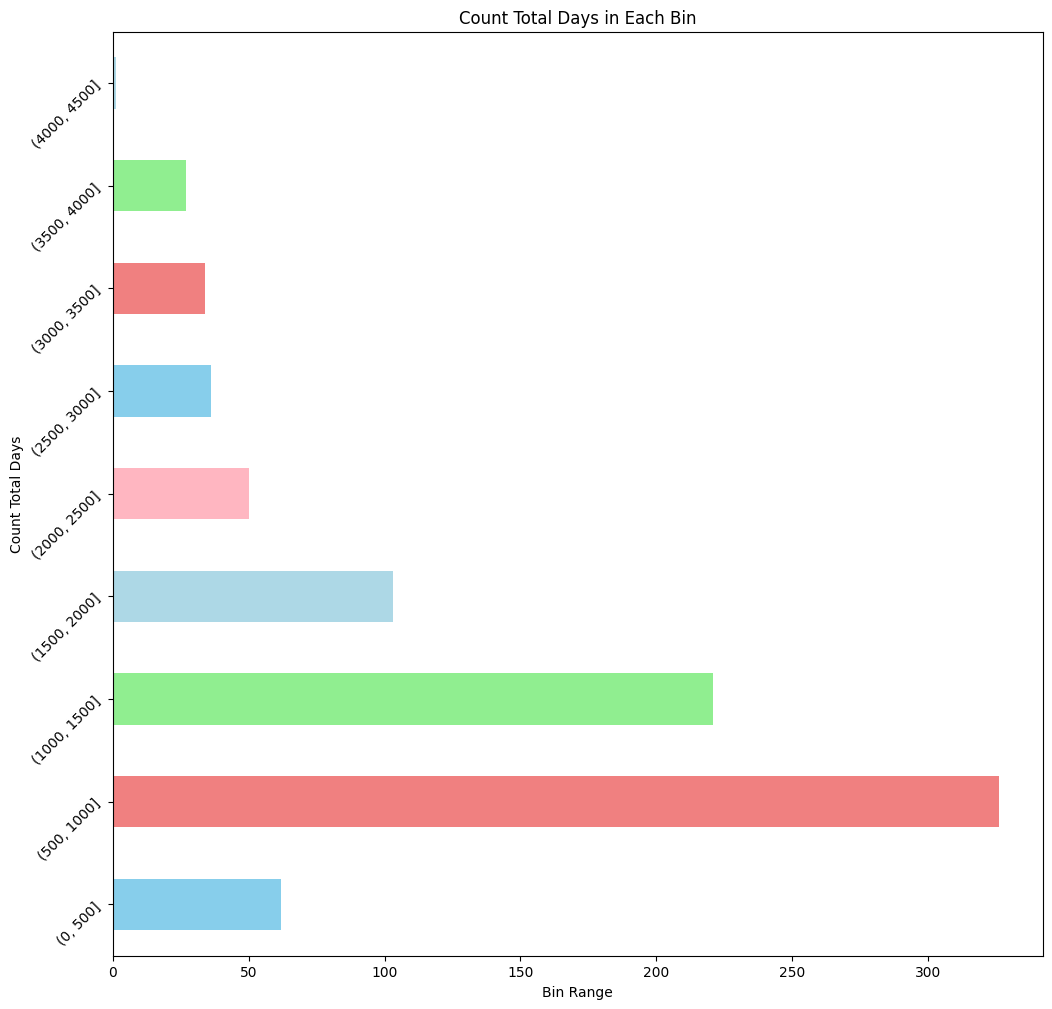

In [16]:
# Create a bar chart for the mean values
plt.figure(figsize=(12, 12))
data_count.plot(kind='barh', color=colors)
plt.xlabel('Bin Range')
plt.ylabel('Count Total Days')
plt.title('Count Total Days in Each Bin')
plt.yticks(range(len(data_count)), data_count.index, rotation=45)
plt.show()

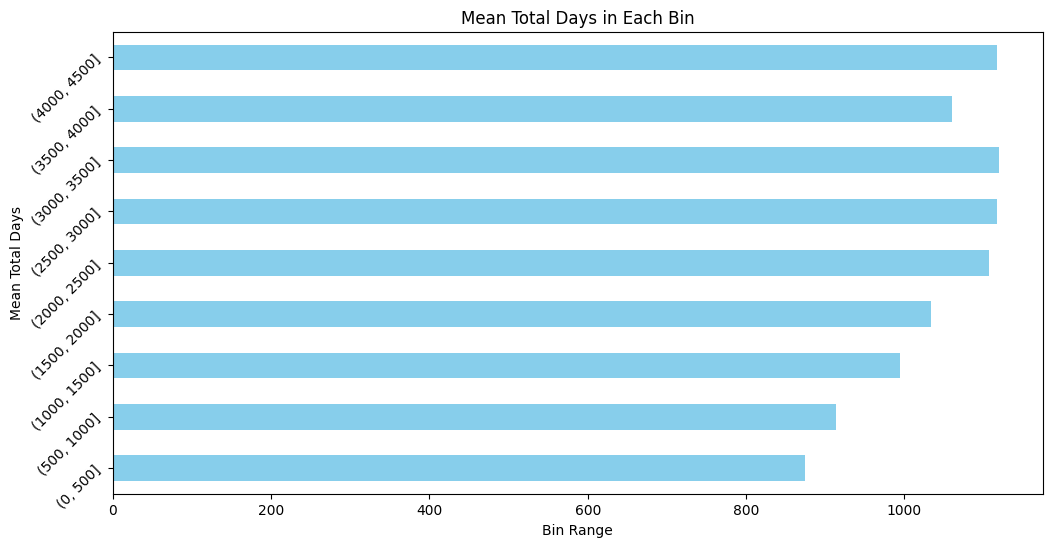

In [17]:
# Create a bar chart for the mean values
plt.figure(figsize=(12, 6))
data_mean.plot(kind='barh', color='skyblue')
plt.xlabel('Bin Range')
plt.ylabel('Mean Total Days')
plt.title('Mean Total Days in Each Bin')
plt.yticks(range(len(data_mean)), data_mean.index, rotation=45)
plt.show()


In [18]:
# Assuming you have your data in a DataFrame named df
# If it's not, you can read your data from a CSV or any other source

# Define the bin edges
bin_width = 500
max_value = int(filtered_data['total_built_up_area_saleable_area'].max())
bin_edges = list(range(0, max_value + bin_width, bin_width))  # Creates bins of size 500

# Create a new column to store the bin labels
filtered_data['area_bin'] = pd.cut(filtered_data['total_built_up_area_saleable_area'], bin_edges)

# Group the data by the 'area_bin' column
grouped = filtered_data.groupby('area_bin')

# Define the features you want to analyze
features = ['total_days']  # Add more features as needed

# Iterate over the groups and calculate min and max for each feature
for feature in features:
    filtered_data_min = grouped[feature].min()
    filtered_data_max = grouped[feature].max()
    filtered_data_mean = grouped[feature].mean()
    filtered_data_count = grouped[feature].count()
    result = pd.concat([filtered_data_min, filtered_data_max, filtered_data_mean, filtered_data_count], axis=1)
    result.columns = ['Min', 'Max', 'Mean', 'Count']
    print(f"Statistics for '{feature}':")
    print(result)
    print("\n")


Statistics for 'total_days':
              Min   Max         Mean  Count
area_bin                                   
(0, 500]      109  1778   708.051546     97
(500, 1000]   112  3764   809.482143    448
(1000, 1500]  106  2147   897.385382    301
(1500, 2000]  114  2383   991.025641    156
(2000, 2500]  288  3672  1106.887640     89
(2500, 3000]  113  1950  1032.527273     55
(3000, 3500]  143  2334  1132.113208     53
(3500, 4000]  421  2302  1147.459459     37
(4000, 4500]  462  1887  1161.470588     34
(4500, 5000]  469  1836  1043.458333     24
(5000, 5500]  761  1795  1145.214286     14
(5500, 6000]  122  1822  1098.782609     23
(6000, 6500]  418  1604  1081.363636     11
(6500, 7000]  612  1895  1163.600000      5
(7000, 7500]  454   964   786.600000      5
(7500, 8000]  112  1811   652.625000      8




<ipython-input-18-3ac3ef85beec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['area_bin'] = pd.cut(filtered_data['total_built_up_area_saleable_area'], bin_edges)


In [19]:
import pandas as pd
import random
from datetime import timedelta

# Assuming you have your filtered data in a DataFrame named filtered_df
# Ensure you have loaded the necessary libraries and data

# Define the number of data points you want to generate
desired_data_points = 10000  # Change this number as needed

# Create an empty DataFrame to store the augmented data
augmented_data = pd.DataFrame(columns=filtered_data.columns)

# Copy the original data to the augmented DataFrame
augmented_data = augmented_data.append(filtered_data, ignore_index=True)

# Define the range for small changes (you can adjust this)
date_change_range = 7  # Number of days for date changes
area_change_range = 10  # Range for changing area

# Generate additional data points
while len(augmented_data) < desired_data_points:
    # Randomly select an existing row to modify
    index_to_modify = random.randint(0, len(filtered_data) - 1)
    row_to_modify = augmented_data.iloc[index_to_modify].copy()

    # Make small changes to the selected row
    row_to_modify['actual_commencement_date'] += timedelta(days=random.randint(-date_change_range, date_change_range))
    row_to_modify['estimated_finish_date'] += timedelta(days=random.randint(-date_change_range, date_change_range))
    row_to_modify['total_built_up_area_saleable_area'] += random.uniform(-area_change_range, area_change_range)
    row_to_modify['total_area_of_project'] += random.uniform(-area_change_range, area_change_range)

    # Add the modified row to the augmented DataFrame
    augmented_data = augmented_data.append(row_to_modify, ignore_index=True)

    # You may want to truncate the DataFrame to the desired number of data points
    augmented_data = augmented_data[:desired_data_points]

    # Now, augmented_data contains the augmented data with the specified changes


Streaming output truncated to the last 5000 lines.
<ipython-input-19-b5558fb047dd>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_modify, ignore_index=True)
<ipython-input-19-b5558fb047dd>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_modify, ignore_index=True)
<ipython-input-19-b5558fb047dd>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_modify, ignore_index=True)
<ipython-input-19-b5558fb047dd>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_

In [20]:
augmented_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column                                                                     Non-Null Count  Dtype                 
---  ------                                                                     --------------  -----                 
 0   organisation_name                                                          10000 non-null  object                
 1   project_category                                                           10000 non-null  object                
 2   actual_commencement_date                                                   10000 non-null  datetime64[ns]        
 3   estimated_finish_date                                                      10000 non-null  datetime64[ns]        
 4   total_built_up_area_saleable_area                                          10000 non-null  float64               
 5   total_area_of_project                                 

In [21]:
# Assuming you have your data in a DataFrame named df
# If it's not, you can read your data from a CSV or any other source

# Define the bin edges
bin_width = 500
max_value = int(augmented_data['total_built_up_area_saleable_area'].max())
bin_edges = list(range(0, max_value + bin_width, bin_width))  # Creates bins of size 500

# Create a new column to store the bin labels
augmented_data['area_bin'] = pd.cut(augmented_data['total_built_up_area_saleable_area'], bin_edges)

# Group the data by the 'area_bin' column
grouped = augmented_data.groupby('area_bin')

# Define the features you want to analyze
features = ['total_days']  # Add more features as needed

# Iterate over the groups and calculate min and max for each feature
for feature in features:
    augmented_data_min = grouped[feature].min()
    augmented_data_max = grouped[feature].max()
    augmented_data_mean = grouped[feature].mean()
    augmented_data_count = grouped[feature].count()
    result = pd.concat([augmented_data_min, augmented_data_max, augmented_data_mean, augmented_data_count], axis=1)
    result.columns = ['Min', 'Max', 'Mean', 'Count']
    print(f"Statistics for '{feature}':")
    print(result)
    print("\n")


Statistics for 'total_days':
              Min   Max         Mean  Count
area_bin                                   
(0, 500]      109  1778   685.539028    679
(500, 1000]   112  3764   819.154423   3335
(1000, 1500]  106  2147   904.314571   2203
(1500, 2000]  114  2383  1000.585069   1152
(2000, 2500]  288  3672  1113.712121    660
(2500, 3000]  113  1950  1025.952970    404
(3000, 3500]  143  2334  1168.214834    391
(3500, 4000]  421  2302  1189.461538    273
(4000, 4500]  462  1887  1143.771429    245
(4500, 5000]  469  1836  1040.701220    164
(5000, 5500]  761  1795  1177.161905    105
(5500, 6000]  122  1822  1069.307292    192
(6000, 6500]  418  1604  1146.169811     53
(6500, 7000]  612  1895  1086.500000     34
(7000, 7500]  454   964   784.214286     42
(7500, 8000]  112  1811   699.205882     68




In [22]:
augmented_data.to_csv('augmented_6_floor.csv', index=False)